### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss
from datasets import Dataset, concatenate_datasets

c:\Users\Kyle Castro\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "15_clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# for 23
# binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
#                      'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
#                      'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

#for 15
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Horror', 'Romance', 'Thriller']


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels.astype(np.float32)
        self.processor = processor  # Store the processor as an attribute

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process image using the provided processor
        inputs = self.processor(images=image, return_tensors="pt")
        processed_image = inputs.pixel_values.squeeze(0)  # Remove batch dimension

        return {"pixel_values": processed_image, "labels": label}


In [4]:
image_folder = "sample_images" #sample_images for developing, downloaded_images for final
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            pass
    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

100%|██████████| 258/258 [00:16<00:00, 15.49it/s]


### Sample Posters

Images shape: (1724, 268, 182, 3)
Labels shape: (1724, 13)


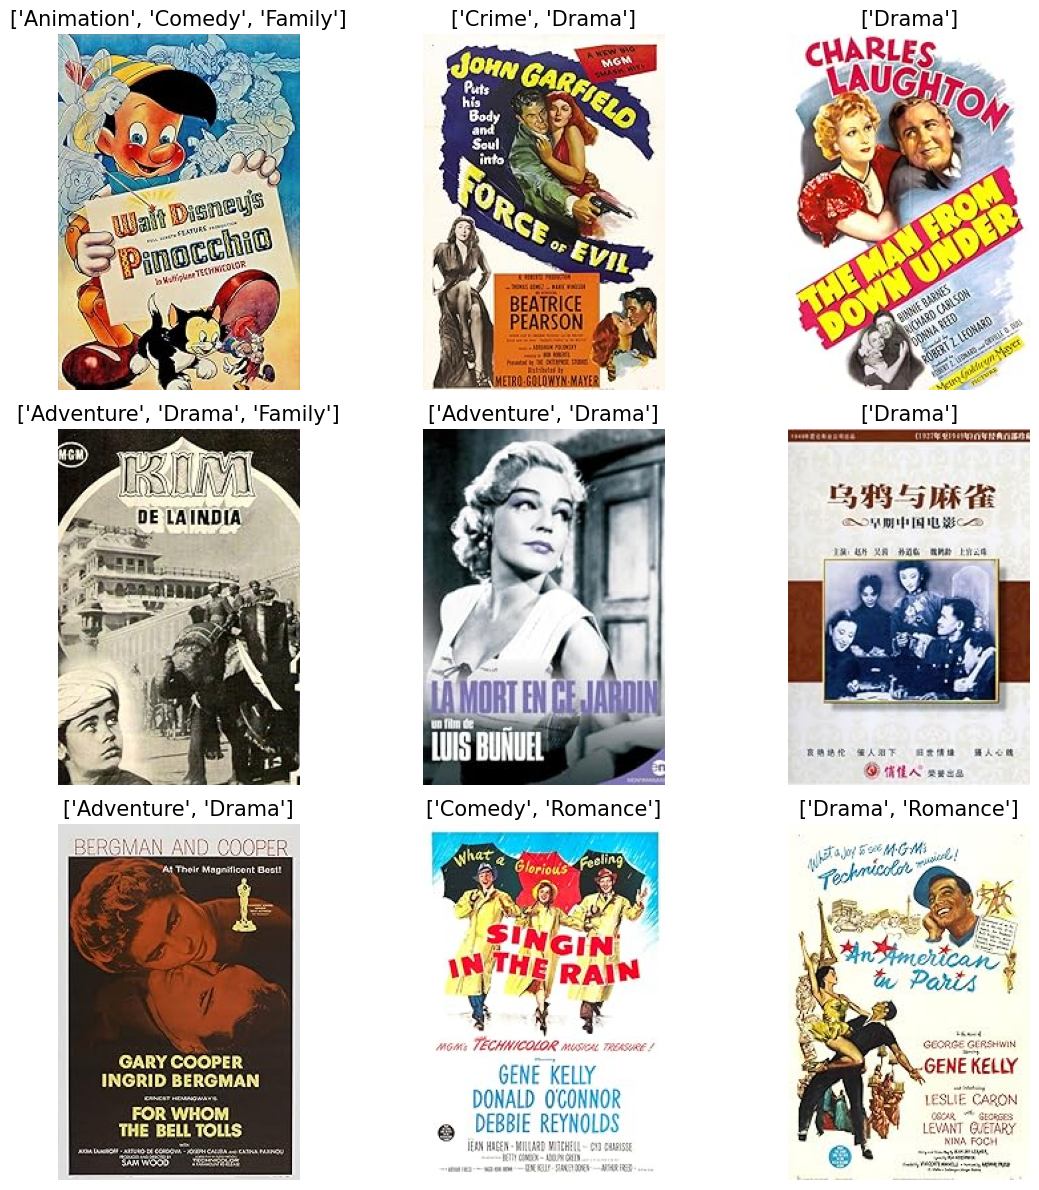

In [5]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation images shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (1379, 268, 182, 3)
Training labels shape: (1379, 13)
Validation images shape: (173, 268, 182, 3)
Validation labels shape: (173, 13)
Testing images shape: (172, 268, 182, 3)
Testing labels shape: (172, 13)


In [7]:
#Display Distribution
train_label_distribution = np.sum(y_train, axis=0)
val_label_distribution = np.sum(y_val, axis=0)
test_label_distribution = np.sum(y_test, axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Validation Distribution": val_label_distribution,
    "Test Distribution": test_label_distribution
}

df = pd.DataFrame(combined_data)
print(df)

          Label  Train Distribution  Validation Distribution  \
0        Action                  79                        8   
1     Adventure                 158                       16   
2     Animation                  18                        3   
3     Biography                  70                        9   
4        Comedy                 409                       53   
5         Crime                 266                       38   
6   Documentary                  10                        2   
7         Drama                 846                      112   
8        Family                  57                        5   
9       Fantasy                  60                        7   
10       Horror                  65                        9   
11      Romance                 342                       52   
12     Thriller                  72                        9   

    Test Distribution  
0                  15  
1                  15  
2                   7  
3      

In [8]:
# Normalize pixel values to the range [0, 1] and convert to float32
X_train = (X_train / 255.0)
X_val = (X_val / 255.0)
X_test = (X_test / 255.0)

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

In [9]:
# Ensure labels are int64
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

In [10]:
def shard_dataset(X, y, shard_size=10000):
    for i in range(0, len(X), shard_size):
        yield {'pixel_values': X[i:i + shard_size], 'labels': y[i:i + shard_size]}

# Shard the training dataset and convert all to datasets
train_dataset = concatenate_datasets([Dataset.from_dict(shard) for shard in shard_dataset(X_train, y_train)])

In [11]:
val_data = {"pixel_values": X_val, "labels": y_val}
test_data = {"pixel_values": X_test, "labels": y_test}

val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

### Modeling

In [12]:
# Load the default ViT model configuration
vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Update the image size in the configuration
vit_config = ViTConfig(
    image_size=(268, 182),
    problem_type="multi_label_classification",
	num_labels=len(binarized_columns),
    is_classifier=True,
    classifier_activation="sigmoid"
)

c:\Users\Kyle Castro\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config, ignore_mismatched_sizes=True)

#utilize cuda if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

# # Utilize MPS backend if available (specific to Apple Silicon)
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# print("Using device:", device)
# model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 177, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


### Training

In [14]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    
    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
    
    # Define a threshold to get binary predictions
    threshold = 0.5
    predictions = (probabilities > threshold).astype(int)
    
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        'f1_weighted': f1_weighted
    }

In [15]:
# Calculate class weights based on the class distribution in the training data
class_counts = np.sum(y_train, axis=0)
total_samples = len(y_train)
class_weights = torch.tensor(total_samples / (len(binarized_columns) * class_counts), dtype=torch.float32)

# Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Define the loss function with class weights
        loss_fct = BCEWithLogitsLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [16]:
# Macbook
training_args = TrainingArguments(
    output_dir='output',
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    num_train_epochs=3,             
    logging_dir='./logs',
    logging_steps=100,               
    save_steps=200,  
    eval_steps=100,               
    evaluation_strategy="steps",  
    # gradient_accumulation_steps=2,  
    learning_rate=2e-5,            
    # weight_decay=0.01,             
    # save_total_limit=2,            
    lr_scheduler_type='cosine_with_restarts',  # Example of using a cosine annealing LR scheduler
)

c:\Users\Kyle Castro\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [18]:
trainer.train()

 19%|█▉        | 100/519 [08:18<38:09,  5.46s/it]

{'loss': 0.7475, 'grad_norm': 0.8010252118110657, 'learning_rate': 1.8223220412041552e-05, 'epoch': 0.58}



 19%|█▉        | 100/519 [09:05<38:09,  5.46s/it]

{'eval_loss': 0.5526713728904724, 'eval_f1_weighted': 0.2496594427244582, 'eval_runtime': 46.6604, 'eval_samples_per_second': 3.708, 'eval_steps_per_second': 0.471, 'epoch': 0.58}


 39%|███▊      | 200/519 [18:11<29:35,  5.56s/it]  

{'loss': 0.5098, 'grad_norm': 0.6023468375205994, 'learning_rate': 1.3524270789003362e-05, 'epoch': 1.16}



 39%|███▊      | 200/519 [18:59<29:35,  5.56s/it]

{'eval_loss': 0.4810115694999695, 'eval_f1_weighted': 0.2725327250013579, 'eval_runtime': 48.0189, 'eval_samples_per_second': 3.603, 'eval_steps_per_second': 0.458, 'epoch': 1.16}


 58%|█████▊    | 300/519 [27:15<18:35,  5.09s/it]  

{'loss': 0.4548, 'grad_norm': 0.5654321908950806, 'learning_rate': 7.572950685897295e-06, 'epoch': 1.73}


                                                 
 58%|█████▊    | 300/519 [27:58<18:35,  5.09s/it]

{'eval_loss': 0.44609761238098145, 'eval_f1_weighted': 0.2725327250013579, 'eval_runtime': 43.0321, 'eval_samples_per_second': 4.02, 'eval_steps_per_second': 0.511, 'epoch': 1.73}


 77%|███████▋  | 400/519 [35:52<08:45,  4.41s/it]  

{'loss': 0.4113, 'grad_norm': 0.564501941204071, 'learning_rate': 2.4840969188444754e-06, 'epoch': 2.31}


                                                 
 77%|███████▋  | 400/519 [36:33<08:45,  4.41s/it]

{'eval_loss': 0.43146175146102905, 'eval_f1_weighted': 0.2725327250013579, 'eval_runtime': 40.8731, 'eval_samples_per_second': 4.233, 'eval_steps_per_second': 0.538, 'epoch': 2.31}


 96%|█████████▋| 500/519 [44:38<01:34,  4.95s/it]

{'loss': 0.4258, 'grad_norm': 0.5794948935508728, 'learning_rate': 6.60637877258874e-08, 'epoch': 2.89}


                                                 
 96%|█████████▋| 500/519 [45:20<01:34,  4.95s/it]

{'eval_loss': 0.4286472499370575, 'eval_f1_weighted': 0.2725327250013579, 'eval_runtime': 41.6817, 'eval_samples_per_second': 4.151, 'eval_steps_per_second': 0.528, 'epoch': 2.89}


100%|██████████| 519/519 [46:49<00:00,  5.41s/it]

{'train_runtime': 2809.9803, 'train_samples_per_second': 1.472, 'train_steps_per_second': 0.185, 'train_loss': 0.505794658366885, 'epoch': 3.0}


TrainOutput(global_step=519, training_loss=0.505794658366885, metrics={'train_runtime': 2809.9803, 'train_samples_per_second': 1.472, 'train_steps_per_second': 0.185, 'total_flos': 3.1161441939849754e+17, 'train_loss': 0.505794658366885, 'epoch': 3.0})

### Testing

In [19]:
model = trainer.model

In [20]:
# Ensure processor has the correct image size
processor.size = (268, 182)  # Set the processor size to match the model

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

# Perform inference
model.eval()
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_images = X_test[i:i+batch_size]
    processed_images = []
    for img in batch_images:
        # Convert float32 to uint8 and transpose if necessary
        img_uint8 = (img * 255).astype(np.uint8)
        img_rgb = np.transpose(img_uint8, (1, 2, 0))  # Transpose to (height, width, channels)
        processed_images.append(img_rgb)
    
    # Convert numpy arrays to lists of PIL images and process
    batch_inputs = processor(images=[Image.fromarray(img) for img in processed_images], return_tensors="pt") 
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)

Using device: cpu


In [82]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [83]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='macro')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

# Calculate overall F1 score using micro and weighted averages
f1_micro = f1_score(y_test_np, predicted_labels_np, average='samples')
f1_weighted = f1_score(y_test_np, predicted_labels_np, average='weighted')

# Create DataFrame to display label-wise metrics
data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Print the overall F1 scores
print("\nMicro-averaged F1 score:", f1_micro)
print("Weighted-averaged F1 score:", f1_weighted)

# Compute average F1 score per label
avg_f1_score = np.mean(f1_scores)
print("Average F1 score (per label):", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

          Label  F1 Score  Accuracy
0        Action  0.477204  0.912791
1     Adventure  0.477204  0.912791
2     Animation  0.489614  0.959302
3     Biography  0.491124  0.965116
4        Comedy  0.404844  0.680233
5         Crime  0.443366  0.796512
6   Documentary  0.495601  0.982558
7         Drama  0.376812  0.604651
8        Family  0.485030  0.941860
9       Fantasy  0.491124  0.965116
10       Horror  0.491124  0.965116
11      Romance  0.445161  0.802326
12     Thriller  0.488095  0.953488

Micro-averaged F1 score: 0.44379844961240306
Weighted-averaged F1 score: 0.2578184591914569
Average F1 score (per label): 0.46586950318712944
Average accuracy: 0.8801431127012525


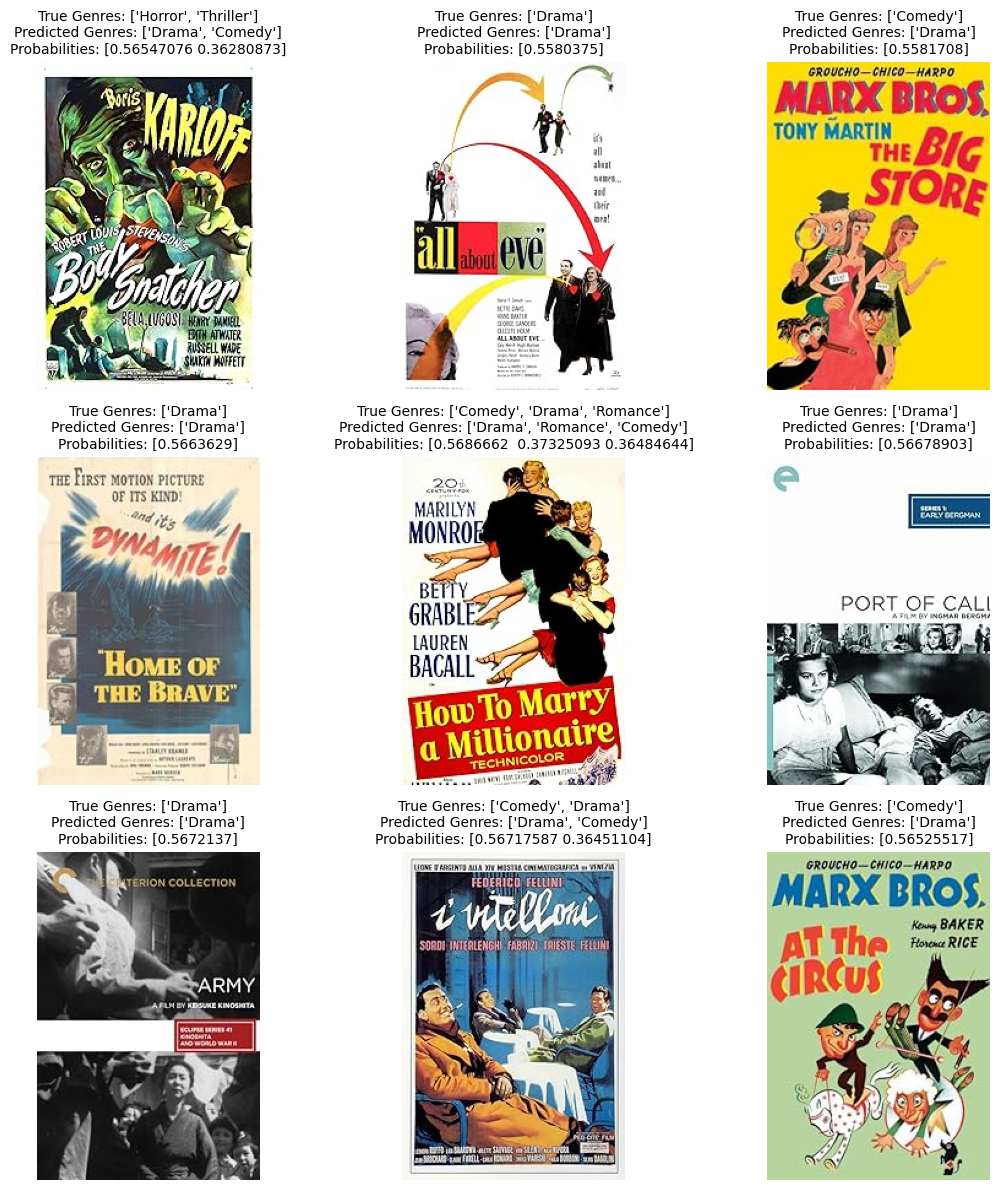

In [84]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx].transpose(1, 2, 0)  # Transpose back to (height, width, channels)
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
